## Libraries

In [1]:
# libraries
import numpy as np
import sys
sys.path.append("../backend/")
%matplotlib inline
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# EMUstack
import objects
import materials
import plotting
from stack import *

#parallel computation
from multiprocessing import cpu_count
from joblib import Parallel, delayed
num_cores = cpu_count() # number of threads -> usually equal to number of cores


##################################################################
EMUstack is brought to you by Bjorn Sturmberg, Kokou Dossou, 
Felix Lawrence & Lindsay Botton, with support from CUDOS & ARENA
Starting EMUstack calculation ...
##################################################################



/home/giovi/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## EMUstack: Ge nanodisk array instability
* This seems a relatively simple calculation to perform, yet EMUstack struggles to get the correct results and most times every combination of (lc_bkg,lc2,lc3) parameters lead to a meaningless result. On top of that (lc_bkg,lc2,lc3)=(0.05,5.0,5.0) seems a very fine mesh to get the right result. Anyway, as is shown below, both finer and coarser meshes lead to the wrong results.
* The odd thing is that the code does not break down, but instead seems to converge deterministically to a wrong output
* The results for (lc_bkg,lc2,lc3)=(0.05,5.0,5.0) have been checked with Stanford S4 RCWA output and there is quantitative agreement
* The real problem lies in the fact that I would like to couple EMUstack with a genetic optimizer to optimize the local field enhancement in the array. Nevertheless, if the output is so erratic, I cannot be sure that the optimizer will converge to a meaningful structure

In [10]:
# light parameters
wl_1 = 8000
wl_2 = 16000
n_wl = 64

# Set up light objects
wavelengths = np.linspace(wl_1,wl_2, n_wl)
light_list  = [objects.Light(wl, max_order_PWs = 2,theta=0.0,phi=0.0) for wl in wavelengths]

# nanodisk array r and pitch in nm
nd_r = 500
nd_p = 2000
nd_h = 500

# Nanodisk array, working parameters
NHs = objects.NanoStruct('2D_array', nd_p, 2.0*nd_r, height_nm = nd_h,
    inclusion_a = materials.Ge_Doped, background = materials.Air, loss = True,
    inc_shape='circle',
    plotting_fields=True,plot_real=1,
    make_mesh_now = True, force_mesh = True, lc_bkg = 0.08, lc2= 5.0, lc3= 5.0,plt_msh=True)#lc_bkg = 0.08, lc2= 5.0)

superstrate = objects.ThinFilm(period = nd_p, height_nm = 'semi_inf',
    material = materials.Air, loss = False)
substrate   = objects.ThinFilm(period = nd_p, height_nm = 'semi_inf',
    material = materials.Air, loss = False)

Exception ignored in: <_io.FileIO name='../backend/fortran/msh/1_msh_template.geo' mode='rb'>
Exception ignored in: <_io.FileIO name='../backend/fortran/msh/2000_0_2000_0_1000_0.geo' mode='wb'>


In [11]:
# EMUstack Function
def simulate_stack(light):

    # evaluate each layer individually 
    sim_NHs          = NHs.calc_modes(light)
    sim_superstrate  = superstrate.calc_modes(light)
    sim_substrate    = substrate.calc_modes(light)

    # build the stack solution
    stackSub = Stack((sim_substrate, sim_NHs, sim_superstrate))
    stackSub.calc_scat(pol = 'TM')

    return stackSub

In [12]:
%%time
# computation
stacks_list=Parallel(n_jobs=num_cores)(delayed(simulate_stack)(light) for light in light_list)

CPU times: user 14.4 s, sys: 19.4 s, total: 33.8 s
Wall time: 4min 43s


In [13]:
# Nanodisk array, bad parameters
NHs_bad = objects.NanoStruct('2D_array', nd_p, 2.0*nd_r, height_nm = nd_h,
    inclusion_a = materials.Ge_Doped, background = materials.Air, loss = True,
    inc_shape='circle',
    plotting_fields=True,plot_real=1,
    make_mesh_now = True, force_mesh = True, lc_bkg = 0.07, lc2= 5.0, lc3= 5.0,plt_msh=True)#lc_bkg = 0.08, lc2= 5.0)

Exception ignored in: <_io.FileIO name='../backend/fortran/msh/1_msh_template.geo' mode='rb'>
Exception ignored in: <_io.FileIO name='../backend/fortran/msh/2000_0_2000_0_1000_0.geo' mode='wb'>


In [14]:
# bad sim
def simulate_stack_bad(light):

    # evaluate each layer individually 
    sim_NHs          = NHs_bad.calc_modes(light)
    sim_superstrate  = superstrate.calc_modes(light)
    sim_substrate    = substrate.calc_modes(light)

    # build the stack solution
    stackSub = Stack((sim_substrate, sim_NHs, sim_superstrate))
    stackSub.calc_scat(pol = 'TM')

    return stackSub

In [15]:
%%time
stacks_list_bad=Parallel(n_jobs=num_cores)(delayed(simulate_stack_bad)(light) for light in light_list)

CPU times: user 12.9 s, sys: 19.9 s, total: 32.8 s
Wall time: 5min 55s


# EMUstack Spectra plot

In [16]:
# spectra function
def emu_spectra(stacks_list):
    
    a_list = []
    t_list = []
    r_list = []
    for stack in stacks_list:
        a_list.extend(stack.a_list)
        t_list.extend(stack.t_list)
        r_list.extend(stack.r_list)
    layers_steps = len(stacks_list[0].layers) - 1
    a_tot      = []
    t_tot      = []
    r_tot      = []
    for i in range(len(wavelengths)):
        a_tot.append(float(a_list[layers_steps-1+(i*layers_steps)]))
        t_tot.append(float(t_list[layers_steps-1+(i*layers_steps)]))
        r_tot.append(float(r_list[i]))
        
    return np.array(r_tot),np.array(t_tot),np.array(a_tot)

In [17]:
# spectra
r_tot,t_tot,a_tot = emu_spectra(stacks_list)
r_tot_bad,t_tot_bad,a_tot_bad = emu_spectra(stacks_list_bad)

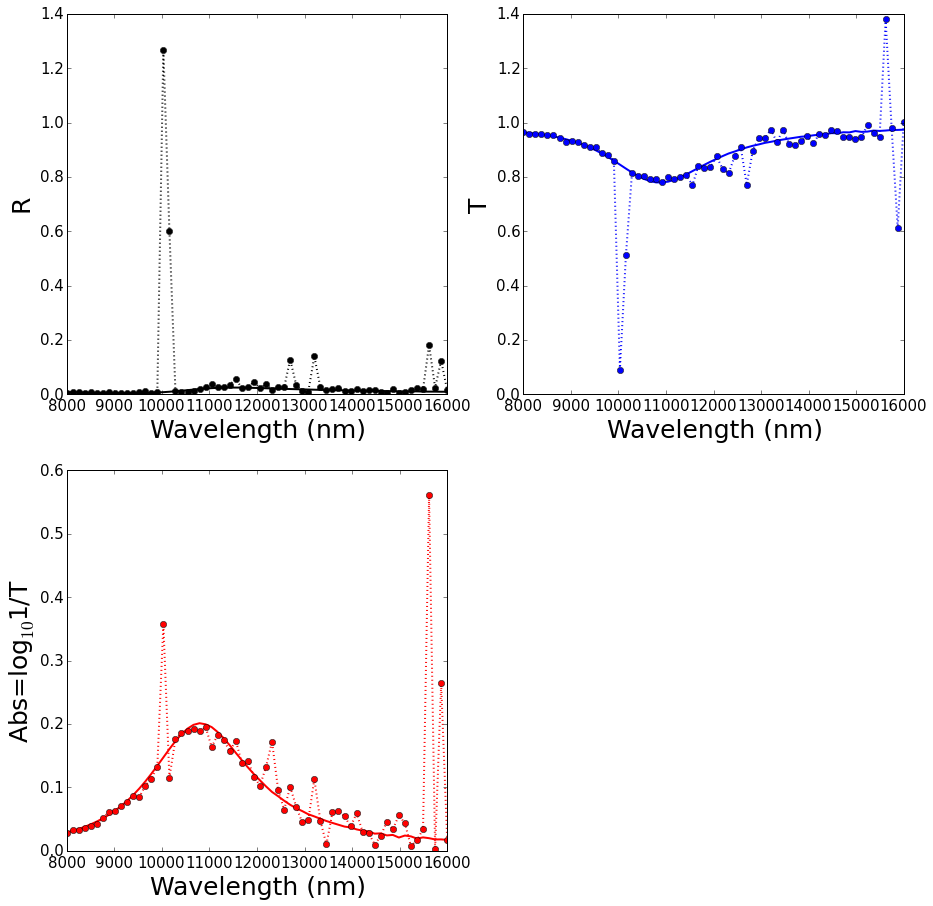

In [50]:
# R, T and abs spectra
plt.figure(figsize=(15,15))


plt.subplot(2,2,1)
plt.plot(wavelengths,np.array(r_tot),'k',
         wavelengths,np.array(r_tot_bad),'k:o',
         linewidth = 2.0);
f_size=25;

# labels
plt.xlabel("Wavelength (nm)",fontsize = f_size);
plt.ylabel("R",fontsize = f_size);

# ticks
plt.xticks(fontsize=f_size-10);
plt.yticks(fontsize=f_size-10);

plt.subplot(2,2,2)
plt.plot(wavelengths,np.array(t_tot),'b',
         wavelengths,np.array(t_tot_bad),'b:o',
         linewidth = 2.0);
f_size=25;

# labels
plt.xlabel("Wavelength (nm)",fontsize = f_size);
plt.ylabel("T",fontsize = f_size);

# ticks
plt.xticks(fontsize=f_size-10);
plt.yticks(fontsize=f_size-10);

plt.subplot(2,2,3)
plt.plot(wavelengths,a_tot,'r',
         wavelengths,a_tot_bad,'r:o',
         linewidth = 2.0);
f_size=25;

# labels
plt.xlabel("Wavelength (nm)",fontsize = f_size);
plt.ylabel(r"Abs=log$_{10}$1/T",fontsize = f_size);

# ticks
plt.xticks(fontsize=f_size-10);
plt.yticks(fontsize=f_size-10);

# EMUstack Triangulation field plot

In [53]:
# triangular interpolation computation
ReEx,ImEx,ReEy,ImEy,ReEz,ImEz,AbsE = plotting.fields_interpolator_in_plane(stacks_list[np.array(t_tot).argmin()],
                                                                           lay_interest=1,
                                                                           z_value=250)
ReEx_b,ImEx_b,ReEy_b,ImEy_b,ReEz_b,ImEz_b,AbsE_b = plotting.fields_interpolator_in_plane(stacks_list_bad[np.array(t_tot_bad).argmax()],
                                                                                         lay_interest=1,
                                                                                         z_value=250)

# field mapping
n_points=500
v_x=np.zeros(n_points**2)
v_y=np.zeros(n_points**2)
i=0
x_min=0.0;x_max=1.0
y_min=-1.0;y_max=0.0
for x in np.linspace(x_min,x_max,n_points):
    for y in np.linspace(y_min,y_max,n_points):
        v_x[i] = x
        v_y[i] = y
        i+=1
v_x = np.array(v_x)
v_y = np.array(v_y)

# interpolated fields
m_ReEx = ReEx(v_x,v_y).reshape(n_points,n_points)
m_ReEy = ReEy(v_x,v_y).reshape(n_points,n_points)
m_ReEz = ReEz(v_x,v_y).reshape(n_points,n_points)
m_ImEx = ImEx(v_x,v_y).reshape(n_points,n_points)
m_ImEy = ImEy(v_x,v_y).reshape(n_points,n_points)
m_ImEz = ImEz(v_x,v_y).reshape(n_points,n_points)
m_AbsE = AbsE(v_x,v_y).reshape(n_points,n_points)
v_plots = [m_ReEx,m_ReEy,m_ReEz,m_ImEx,m_ImEy,m_ImEz,m_AbsE]

# interpolated fields
m_ReEx_b = ReEx_b(v_x,v_y).reshape(n_points,n_points)
m_ReEy_b = ReEy_b(v_x,v_y).reshape(n_points,n_points)
m_ReEz_b = ReEz_b(v_x,v_y).reshape(n_points,n_points)
m_ImEx_b = ImEx_b(v_x,v_y).reshape(n_points,n_points)
m_ImEy_b = ImEy_b(v_x,v_y).reshape(n_points,n_points)
m_ImEz_b = ImEz_b(v_x,v_y).reshape(n_points,n_points)
m_AbsE_b = AbsE_b(v_x,v_y).reshape(n_points,n_points)
v_plots_b = [m_ReEx_b,m_ReEy_b,m_ReEz_b,m_ImEx_b,m_ImEy_b,m_ImEz_b,m_AbsE_b]


v_labels = ["ReEx","ReEy","ReEz","ImEx","ImEy","ImEz","AbsE"]
v_labels_bad = ["ReEx_bad","ReEy_bad","ReEz_bad","ImEx_bad","ImEy_bad","ImEz_bad","AbsE_bad"]

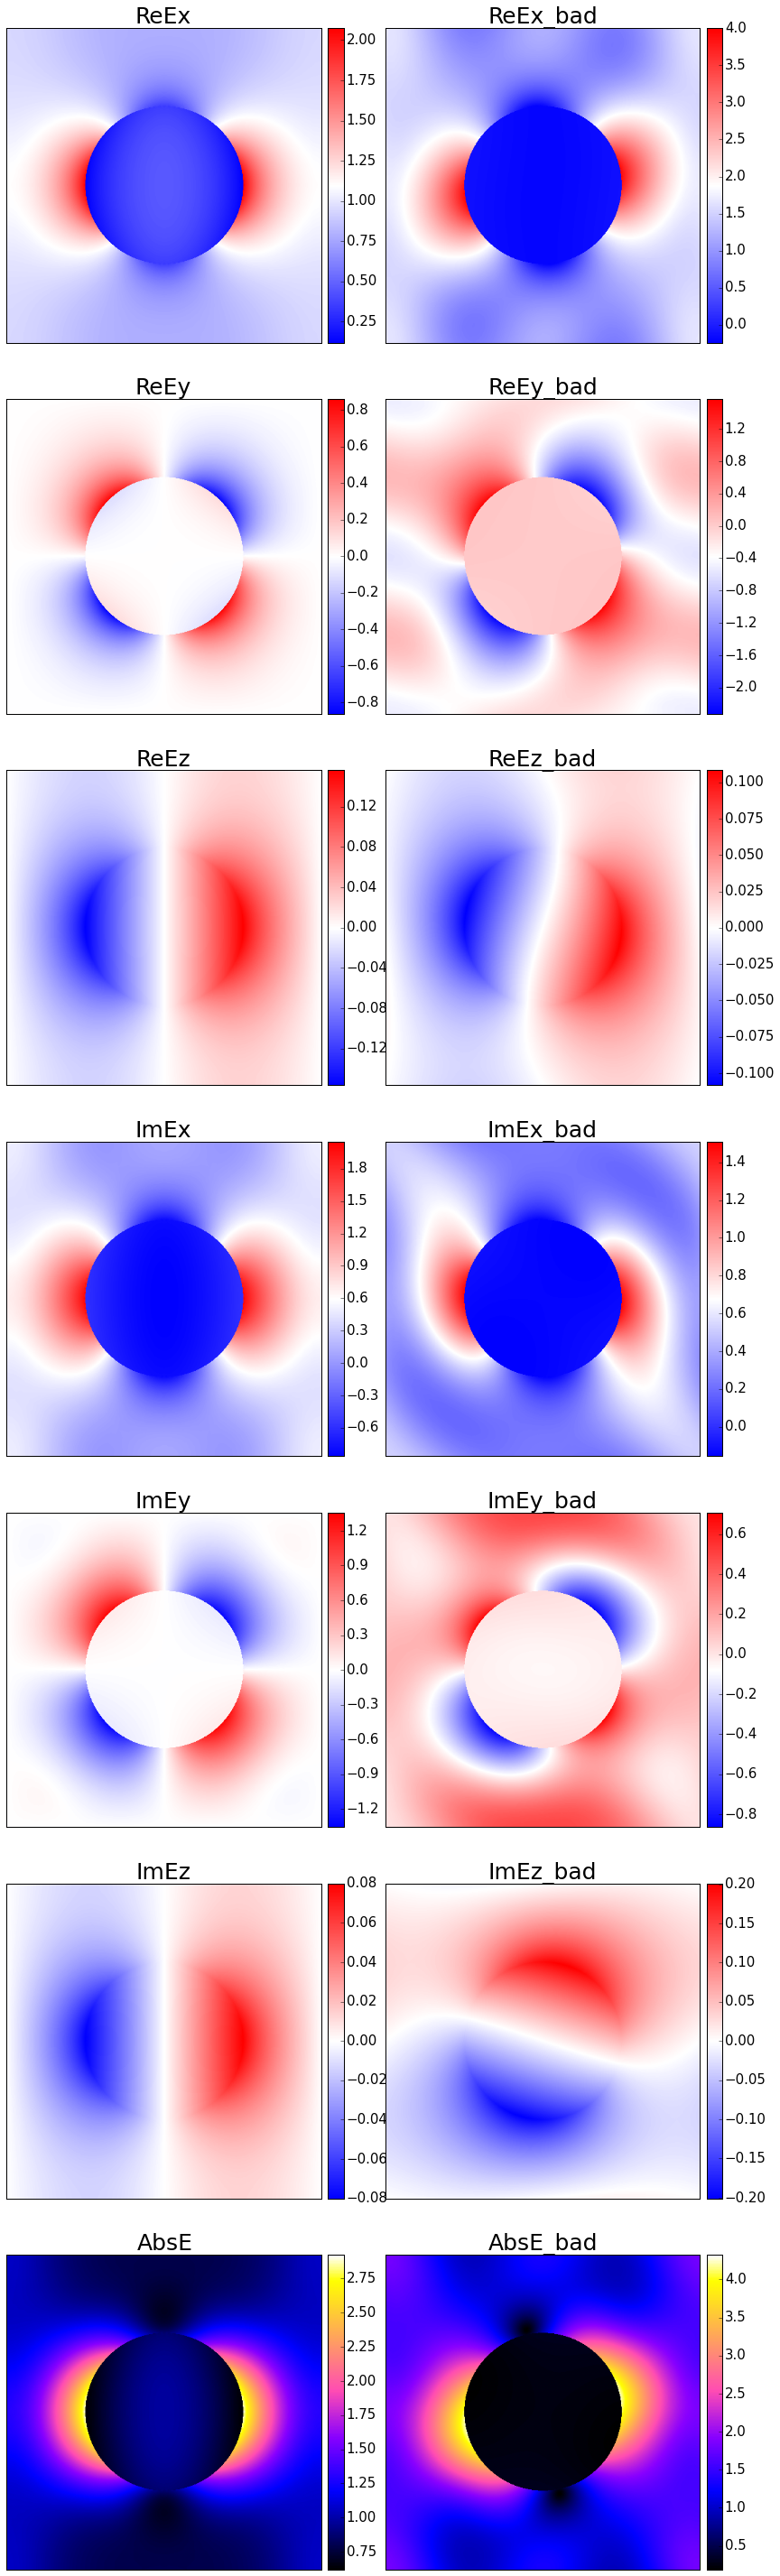

In [54]:
# field plots
plt.figure(figsize=(12,40))
for i_p,(plot,plot_b) in enumerate(zip(v_plots,v_plots_b)):
    
    # only even indexes
#     print("one",i_p)
#     if i_p % 2 !=0:
#         continue
    
    # good then bad plot
    for i in [0,1]:
#         print("index",2*i_p+1+i)
        ax = plt.subplot(7,2,2*i_p+1+i)
        if 2*i_p+1+i>2*len(v_plots)-2:
            color='gnuplot2'
        else:
            color='bwr'
        if i==0:
            plot_ok = plot
        else:
            plot_ok = plot_b
        im = plt.imshow(plot_ok.T,cmap=color);

        # no ticks
        plt.xticks([])
        plt.yticks([])

        # titles
        if i==0:
            v_labels_ok = v_labels
        else:
            v_labels_ok = v_labels_bad
        plt.title(v_labels_ok[i_p],fontsize=f_size)

        # colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=f_size-10) 
plt.tight_layout(1)